In [1]:
import sys
sys.path.append('..')

In [2]:
from utils import io

In [3]:
import numpy as np
import torch
import os.path as osp
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [84]:
_node_groups = io.load_pickle('/home/sxr/data/social_and_user_item/model_outputs/gnn_pokec/partition/metis100/node_groups.pkl')

In [85]:
np.random.seed(2022)
for group in _node_groups:
    np.random.shuffle(group)

In [86]:
num_select_groups = 8
all_group_id = np.arange(len(_node_groups))
np.random.shuffle(all_group_id)
select_groups = all_group_id[:num_select_groups]
_node_groups = [_node_groups[i] for i in select_groups]

In [87]:
num_sample_per_group = 500
node_groups = []
_nid = 0
local_idx = []
for group in _node_groups:
    group_nids = group[:num_sample_per_group]
    node_groups.append(group_nids)
    local_idx.append(np.arange(_nid, _nid + len(group_nids)))
    _nid += len(group_nids)

In [88]:
emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_pokec/n2v_best/out_emb_table.pt'
# emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_pokec/plot/pprgo/[best][bpr][reg0]/out_emb_table.pt'
# emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_pokec/plot/dnn-lightgcn-final_version/[gcn1layer][scale][3layer][freq3][K10][endure3]/out_emb_table.pt'

# emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_livejournal/n2v_best/out_emb_table.pt'
# emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_livejournal/plot/pprgo/[best][bpr][reg0]/out_emb_table.pt'
# emb_file = '/home/sxr/data/social_and_user_item/_model_outputs/gnn_livejournal/plot/dnn-lightgcn-final_version/[gcn2layer][scale][3layer][freq1][K10][endure3]/out_emb_table.pt'
out_emb_table = torch.load(emb_file,
                           map_location='cpu').detach().numpy()

In [89]:
embs = []
for nids in node_groups:
    embs.append(out_emb_table[nids])
embs = np.concatenate(embs)
embs.shape

(4000, 64)

In [90]:
X = TSNE(n_components=2, perplexity=100.0).fit_transform(embs)
X

/home/sxr/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sxr/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[-11.106704 ,  17.204817 ],
       [ -8.934327 ,  10.275156 ],
       [ -6.056405 ,   9.738735 ],
       ...,
       [  7.4035544, -15.586202 ],
       [  6.3657813,  -3.7608886],
       [  7.520079 , -12.2685375]], dtype=float32)

In [91]:
colors = ['red', 
          'lawngreen', 
          'orangered',
          'deepskyblue', 
          'mediumspringgreen',
          'cyan', 
          'darkorchid', 
          'deeppink', 
          'yellow',
]

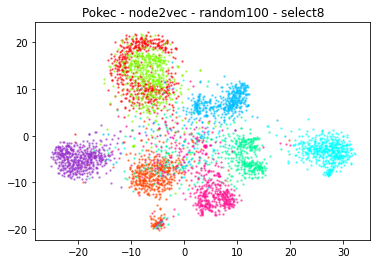

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1)

for i in range(len(local_idx)):
    idx = local_idx[i]
    x = X[idx]
    color = colors[i]
    ax.scatter(x[:, 0], x[:, 1], color=color, s=2, alpha=0.5)

title = 'Pokec - node2vec - random100 - select8'
ax.set_title(title)

# results_root = '/home/sxr/data/social_and_user_item/figure'
# fig.savefig(osp.join(results_root, title + '.svg'), format='svg', dpi=200)
plt.show()